In [1]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# This cell allows for all the output to be displayed without scrolling (up to the max-height var in pixels)

In [1]:
# Import libraries
from APfuncs import *
from ipywidgets import *
from IPython.display import display, Javascript
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline                    # Safe smooth interpolation
from scipy.signal import find_peaks
from scipy.signal import medfilt
from scipy import signal


import peakutils
from peakutils.plot import plot as pplot
from matplotlib.animation import FuncAnimation
import matplotlib

from scipy import stats

from numpy.fft import fft, fftfreq, ifft

import glob

from tqdm import tqdm

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import os
from scipy.optimize import curve_fit
from ipywidgets import *
from IPython.display import display, Javascript


from renishawWiRE import WDFReader

import selenium
import os
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By

ModuleNotFoundError: No module named 'renishawWiRE'

In [ ]:
#Constatns
h = 6.626e-34 #Planck's constant in Js
heV = 4.136e-15 #Planck's constant in eVs
c = 2.9979e8 #Speed of light in m/s
kb = 1.381e-23 #Boltzmann constant in J/K
kbeV = 8.617e-5 #Boltzmann constant in eV/K
scale = 2e-9

In [ ]:
class SelectFilesButton(widgets.Button):
    """A file widget that leverages tkinter.filedialog."""

    def __init__(self, *args, **kwargs):
        """Initialize the SelectFilesButton class."""
        super(SelectFilesButton, self).__init__(*args, **kwargs)
        # Add the selected_files trait
        self.add_traits(files=traitlets.traitlets.List())
        # Create the button.
        self.description = "Select File"
        self.icon = "square-o"
        self.style.button_color = "orange"
        # Set on click behavior.
        self.on_click(self.select_files)

    @staticmethod
    def select_files(b):
        """Generate instance of tkinter.filedialog.
        Parameters
        ----------
        b : obj:
            An instance of ipywidgets.widgets.Button
        """
        # Create Tk root
        root = Tk()
        # Hide the main window
        root.withdraw()
        # Raise the root to the top of all windows.
        root.call('wm', 'attributes', '.', '-topmost', True)
        # List of selected fileswill be set to b.value
        b.files = filedialog.askopenfilename(multiple=True)
        f = b.files
        '''
        for i in range(0,len(f)):
            print(i,f[i],end="\n")   # load preview cut process plot
        '''
        b.description = "Files Selected"
        b.icon = "check-square-o"
        b.style.button_color = "lightgreen"
        b.layout = Layout( width='auto')

In [ ]:
def get_data(f,i):

    data = pd.read_csv(f[i], sep=None, engine='python', names=['col_a_data','col_b_data',c])
    x = data['col_a_data'].to_numpy()
    y = data['col_b_data'].to_numpy()
    
    return x,y

In [ ]:
def get_data_MAF_RW(f,i):
    
    data = pd.read_csv(f[i], sep='\t', skiprows=1, names=['col_a_data','col_b_data'])
    
    x = data['col_a_data'].to_numpy()
    y = data['col_b_data'].to_numpy()
    
    return x,y

In [ ]:
def data_cleaning(data,erp):
    
    # Code to remove cosmic rays
    #erp=100 # Set percentage error limit
    err=erp/100

    Ndatapts = len(data)
    ydata = data

    for i in range(0,Ndatapts): # This loop removes hot regions one pixel wide
        if i>0 and i<Ndatapts-1:
            if ydata[i]>(1+err)*ydata[i+1] and ydata[i]>(1+err)*ydata[i-1]:
                #print('Entered the loop 1')
                ydata[i]=(ydata[i-1]+ydata[i+1])/2

    for i in range(0,Ndatapts): # This loop removes hot regions up to 3 pixels wide
        if i>1 and i<Ndatapts-2 and ydata[i]>(1+err)*ydata[i+2] and ydata[i]>(1+err)*ydata[i-2]:
            #print('Entered the loop 3')
            ydata[i], ydata[i-1], ydata[i+1] = (ydata[i-2]+ydata[i+2])/2, (ydata[i]+ydata[i-2])/2, (ydata[i+2]+ydata[i])/2

    for i in range(0,Ndatapts): # This loop removes hot regions up to 5 pixels wide
        if i>4 and i<Ndatapts-5 and ydata[i]>(1+err)*ydata[i+5] and ydata[i]>(1+err)*ydata[i-5]:
            #print('Entered the loop 3')
            ydata[i], ydata[i-1], ydata[i-2], ydata[i-3], ydata[i-4], ydata[i+1], ydata[i+2], ydata[i+3], ydata[i+4] = (ydata[i-5]+ydata[i+5])/2, (ydata[i]+ydata[i-2])/2, (ydata[i-1]+ydata[i-3])/2, (ydata[i-2]+ydata[i-4])/2, (ydata[i-3]+ydata[i-5])/2, (ydata[i+2]+ydata[i])/2, (ydata[i+3]+ydata[i+1])/2, (ydata[i+4]+ydata[i+2])/2, (ydata[i+5]+ydata[i+3])/2

    for i in range(0,Ndatapts): # This loop removes dead regions one pixel wide
        if i>0 and i<Ndatapts-1 and ydata[i]<(1-err)*ydata[i+1] and ydata[i]<(1-err)*ydata[i-1]:
            #print('Entered the loop 4')
            ydata[i]=(ydata[i-1]+ydata[i+1])/2

    for i in range(0,Ndatapts): # This loop removes dead regions up to 3 pixels wide
        if i>1 and i<Ndatapts-2 and ydata[i]<(1-err)*ydata[i+2] and ydata[i]<(1-err)*ydata[i-2]:
            #print('Entered the loop 5')
            ydata[i], ydata[i-1], ydata[i+1] =(ydata[i-2]+ydata[i+2])/2, (ydata[i]+ydata[i-2])/2, (ydata[i+2]+ydata[i])/2

    #plt.plot(wvl,ydata)
    #plt.show()
    
    return ydata

In [ ]:
def subtract_bsl(data,p_order):
    
    base = peakutils.baseline(data,p_order)
    
    return base

In [ ]:
def filter_savgol(data,k_size,p_order):
    
    data[np.isnan(data)] = 0
    
    sav_filt_data=signal.savgol_filter(data,k_size,p_order)
    
    return sav_filt_data

In [2]:
def filter_median(data,k_size):
    
    filt_data = medfilt(data,kernel_size=k_size)
 
    #plt.figure()
    #plt.plot(x_data,filt_data,label='Median Filtered Data')
    #plt.plot(wvl,y_data/np.max(y_data),label='Actual Data')
    #plt.plot(peak_x,peak_y/np.max(intens_data),'ob')
    #plt.title(fdata[i])
    #plt.legend()
    #plt.show()
    
    return filt_data

In [3]:
def i_corr(f,i):
    start = 0
    end = -1

    head_i, tail_i = os.path.split(f[i])
    
    ## Important note to change the location of this .txt file below to where it is in your computer.
    calibstd = np.loadtxt(r"G:\Shared drives\Pauzauskie Team Drive\CG\Scripts\030410638_HL-2000-CAL_2014-01-15-14-09_VISEXT1EXT2_FIB.txt")
    xcalib = calibstd[:,0]
    ycalib = calibstd[:,1]

    x,y = get_data(f,i)

    if len(fdark)!=0: #Does background correction if chosen
        xdark, ydark = masterRead(fdark,0)
        xdark=np.asarray(xdark, dtype=np.float32)
        ydark=np.asarray(ydark, dtype=np.float32)
        y=y-ydark
    HglampFunc = CubicSpline(xcalib,ycalib)
    hglampI = HglampFunc(x) # Create interpolation of true lamp spectrum

    hglampdata_x, hglampdata_y = get_data(flamp,0) # Split true lamp spectra into x and y
    
    ICF = hglampI/(hglampdata_y) # Creates ratio of true lamp spectra to real lamp data, ICF = Intensity Correction Factor

    ynew = (y)*ICF # multiplies real data by intensity correction factor

    ynew = np.nan_to_num(ynew,nan=0,posinf=0,neginf=0)
    datamatrix = np.column_stack((x,ynew)) # Compiles corrected data into a new matrix
    savename = f[i][:-4]+"_calib.txt" # Create filename for new data
    
    head_c, tail_c = os.path.split(savename)
    
    np.savetxt(savename,datamatrix) # Save new data

    return x,y,ynew

In [4]:
def press_find(thresh,x_val,y_val,w_size,p_prom):
    


    if len(peak_x)>=1:

        measured_peak = peak_x[np.argmin(np.abs(peak_x-694.55))]

        # Using Chrome to access web
        driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
        # Open the website
        driver.get('http://kantor.50webs.com/ruby.htm')
        driver.implicitly_wait(0.5)
        driver.find_element(By.CLASS_NAME, "lambda").clear()

        driver.find_element(By.CLASS_NAME, "lambda").send_keys(str(measured_peak))
        measured_pressure = float(driver.find_element(By.ID,"pressure").get_attribute('value'))

        #print("Meassured Pressure : %.2f GPa" %measured_pressure)
        driver.close()
      
    return measured_pressure

## Clean the intensity correction data files

In [5]:
#Functions for cleaning intensity correction files
def f1(med_check): ## Median Filtering
    
    if med_check==True:
        
        k_size_med = widgets.IntSlider(value=3,min=1,max=11,step=2,description='Kernel Size',disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='d')
        display(k_size_med)
        
def f2(savgol_check): ## Savgol Filtering
    
    if savgol_check==True:
        
        k_size_savgol = widgets.IntSlider(value=11,min=1,max=53,step=2,description='Kernel Size',disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='d')
        display(k_size_savgol)
        
        p_order_savgol = widgets.IntSlider(value=1,min=1,max=11,step=2,description='Polynomial Order',disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='d')
        display(p_order_savgol)

def f3(clean_check):
    
    if clean_check==True:
        
        style = {'description_width': 'initial'}
        erp = widgets.IntSlider(value=5,min=-10,max=100,step=1,description='Error Percentage %',disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='d',style=style)
        display(erp)

def f(intes_data_check):
    
    #clr_plot = widgets.ToggleButton(value=False,description='Click me',disabled=False,button_style='success',icon='check')
    #display(clr_plt)
    #clr
    
    if intes_data_check ==True:
        
        intes_data_check_value = 0
        
        style = {'description_width': 'initial'}
        
        med_check_w=widgets.Checkbox(value=False,description='Median Filtering',disabled=False,indent=False)
        interact(f1,med_check=med_check_w)
        savgol_check_w=widgets.Checkbox(value=False,description='Savgol Filtering',disabled=False,indent=False)
        interact(f2,savgol_check=savgol_check_w)
        clean_check_w=widgets.Checkbox(value=False,description='Data Cleaning',disabled=False,indent=False)
        interact(f3,clean_check=clean_check_w)
        
        
        print("\nSelect tungsten halogen (Blue Ocean optics HL2000) lamp spectrum for intensity correction \n(optional; if none is chosen, default intensity correction factor will be used): ")
        selectHalLamp_1 = SelectFilesButton()
        display(selectHalLamp_1)
        
        min_val_intensity = widgets.BoundedFloatText(value=550,min=0,max=1000,step=0.1,description='Minimum Intensity',disabled=False,style=style)
        display(min_val_intensity)
        
    else:
        intes_data_check_value = 1
        
    return

<span style="font-family:arial; font-size:16pt;">Set the value of ***max_val_intensity*** to a number. The max of the intensity correction data should be above this value to be considered in further caluclation.
<br>
<br>
The considered intensity correction file names will be printed and saved with ***_cleaned*** at the end of the original name with *.txt* extension.</span>

In [6]:
intes_data_check_w=widgets.Checkbox(value=False,description='Clean lamp data',disabled=False,indent=False)
#display(intes_data_check_w)
interact(f,intes_data_check=intes_data_check_w)
output = widgets.Output()
display(output)

interactive(children=(Checkbox(value=False, description='Clean lamp data', indent=False), Output()), _dom_clas…

Output()

In [38]:
intens_corr_cleaning = 'n'
do_savgol_filtering = True
do_median_filtering = False
do_data_cleaning = True

p_order_savgol = 1
k_size_savgol = 9
erp = -5

print("\nSelect tungsten halogen (Blue Ocean optics HL2000) lamp spectrum for intensity correction \n(optional; if none is chosen, default intensity correction factor will be used): ")
selectHalLamp_1 = SelectFilesButton()
display(selectHalLamp_1)


Select tungsten halogen (Blue Ocean optics HL2000) lamp spectrum for intensity correction 
(optional; if none is chosen, default intensity correction factor will be used): 


SelectFilesButton(description='Select File', icon='square-o', style=ButtonStyle(button_color='orange'))

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Entered if


No handles with labels found to put in legend.
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.89it/s]


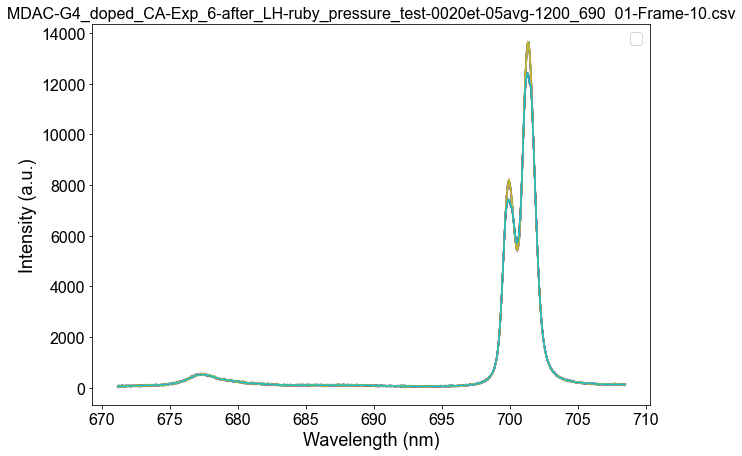

In [39]:
if intens_corr_cleaning == 'n':
    print('Entered if')

    flamp_1=selectHalLamp_1.files
    
    for i in tqdm(range(len(flamp_1))):
        
        head, tail = os.path.split(flamp_1[i])

        x_data,y_data = get_data(flamp_1,i)
        
        if do_savgol_filtering == True:
            savgol_filt_data = filter_savgol(y_data,k_size_savgol,p_order_savgol)
        else:
            savgol_filt_data = y_data

        if do_median_filtering == True:
            filt_data = filter_median(savgol_filt_data,k_size)
        else:
            filt_data = savgol_filt_data

        if do_data_cleaning == True:
            cleaned_data = data_cleaning(filt_data,erp)
        else:
            cleaned_data = filt_data
            
        max_val_intensity = 550 ## set the value of intesnity that an intensity correction file should have to get considered

        if np.max(cleaned_data)>max_val_intensity:
            #print(flamp_1[i])

            datamatrix = np.column_stack((x_data,cleaned_data)) # Compiles corrected data into a new matrix
            savename = flamp_1[i][:-4]+"_cleaned.txt" # Create filename for new data
            np.savetxt(savename,datamatrix) # Save new data
            
            plt.plot(x_data,y_data)
            plt.plot(x_data,cleaned_data)
            #plt.plot(x_data,filt_data)
            #plt.plot(x_data,savgol_filt_data)
            
            plt.xlabel('Wavelength (nm)')
            plt.ylabel('Intensity (a.u.)')
            #plt.ylim(0,1000)
            plt.legend()
            #plt.ylim(100,250)
            plt.title(tail)
    plt.show()
    
else:
    print('Went away')
    pass
    

## Manual Intensity Correction

### Perform intensity correction on the spectra data files

<span style="font-family:arial; font-size:12pt;"> Use the ***_cleaned*** intensity correction file from the above and upload it in the HalLamp below.
    <br>
    <br>
    Upload the all spectra files in the first Select Files button.
    The intensity corrected spectra data files will be stored in the same folder as the original file with a ***_calib*** at the end of the name. You can use this intensity calibrated file for future use and analysis.

In [43]:
print("Select data files you want to analyze: ")
selectFiles = SelectFilesButton()
display(selectFiles)

do_intensity_correction = 'n'

if do_intensity_correction == 'y':
    print("Select data dark BKG: (Optional, don't use if background already subtracted)")
    selectDark = SelectFilesButton()
    display(selectDark)
    print("________________________________________________________________________________________________________")

    print("\nSelect tungsten halogen (Blue Ocean optics HL2000) lamp spectrum for intensity correction \n(optional; if none is chosen, default intensity correction factor will be used): ")
    selectHalLamp = SelectFilesButton()
    display(selectHalLamp)

    print("\nSelect baseline spectrum for tungsten lamp measurement: (Optional, don't use if background already subtracted)")
    selectBaseline = SelectFilesButton()
    display(selectBaseline)
    print("________________________________________________________________________________________________________")

else:
    pass

Select data files you want to analyze: 


SelectFilesButton(description='Select File', icon='square-o', style=ButtonStyle(button_color='orange'))

In [44]:
## Variables

is_MAF_RW_file = 'n'  # 'y', 'n'

do_baseline_subtraction = 'n' # 'y', 'n'
do_median_filtering = 'n' # 'y', 'n'
do_data_cleaning = 'n' # 'y', 'n'
do_savgol_filtering = 'n' # 'y', 'n'
do_conversion = 'n' # 'raman', 'energy', 'n'
do_normalize = 'actual' # 'scale', 'actual', 'n'

p_order = 5 # Polynomial order for baseline subtraction
k_size = 7 # Kernel size for Median Filtering
erp = 5
k_size_savgol = 11
p_order_savgol = 1


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 62.53it/s]


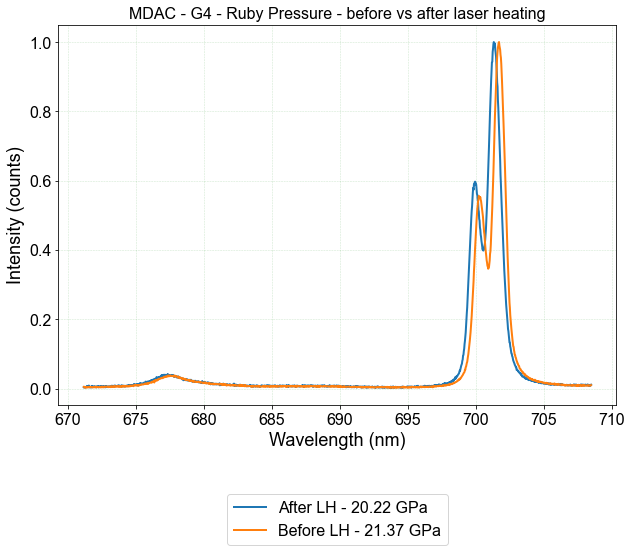

In [50]:
fdata = selectFiles.files

matplotlib.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams["figure.figsize"] = (10, 7)

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

x_range_min = []
x_range_max = []
file_data_df = pd.DataFrame()

x_label = 'Wavelength (nm)'

if do_intensity_correction == 'y':
    fdark = selectDark.files
    flamp = selectHalLamp.files
    flampbase = selectBaseline.files
else:
    pass

laser_power = []
peak_intens = []

counter = 0

fig, ax1 = plt.subplots(1, 1)

mp = []

for i in tqdm(range(len(fdata))):

    head_i, tail_i = os.path.split(fdata[i])

    if is_MAF_RW_file == 'y':
        x_data, y_data = get_data_MAF_RW(fdata, i)
        x_label = 'Raman shift(cm$^{-1}$)'

    else:
        x_data, y_data = get_data(fdata, i)

    if do_intensity_correction == 'y':
        x_data, y_data, intens_data = i_corr(fdata, i)
    else:
        intens_data = y_data

    if do_normalize == 'scale':
        norm_intens_data = (intens_data - np.min(intens_data)) / (np.max(intens_data) - np.min(intens_data))
    elif do_normalize == 'actual':
        norm_intens_data = intens_data / np.max(intens_data)
    else:
        norm_intens_data = intens_data

    if do_median_filtering == 'y':
        filt_data = filter_median(norm_intens_data, k_size)
    else:
        filt_data = norm_intens_data

    if do_baseline_subtraction == 'y':
        base = subtract_bsl(filt_data, p_order)
    else:
        base = 0

    bsl_subt_data = filt_data - base

    if do_data_cleaning == 'y':
        cleaned_data = data_cleaning(bsl_subt_data, erp)
    else:
        cleaned_data = bsl_subt_data

    if do_savgol_filtering == 'y':
        savgol_filt_data = filter_savgol(cleaned_data, k_size_savgol,p_order_savgol)
    else:
        savgol_filt_data = cleaned_data

    if do_conversion == 'raman':
        x_val = 10**7 / 532 - 10**7 / x_data
        x_label = 'Raman shift(cm$^{-1}$)'
        y_val = savgol_filt_data
    elif do_conversion == 'energy':
        x_val = 1232 / x_data
        x_label = 'Energy(eV)'
        y_val = (1232 / (x_data**2)) * y_data
    else:
        x_val = x_data
        y_val = savgol_filt_data

    ### Pressure finding

    w_size = 9
    p_prom = 0
    thresh = 0.3
    
    # mp = np.append(mp,press_find(thresh,x_val,y_val,w_size,p_prom))
    
    peak_x = x_val[find_peaks(y_val,width=w_size,prominence=p_prom)[0]]
    peak_y = savgol_filt_data[find_peaks(y_val,width=w_size,prominence=p_prom)[0]]
    #print(peak_x, peak_y)
    
    lab = ['After LH - 20.22 GPa', 'Before LH - 21.37 GPa']
    
    ax1.set_title("MDAC - G4 - Ruby Pressure - before vs after laser heating")
    ax1.set_xlabel(x_label)
    ax1.set_ylabel('Intensity (counts)')

    if  np.max(y_val)>thresh:
        #mp = np.append(mp,press_find(thresh,x_val,y_val,w_size,p_prom))
        # ax1.plot(x_val, y_data/np.max(y_data), color='r', label='Actual Data')
        ax1.plot(x_val, y_val, lw=2, label=lab[i])
        #ax1.plot(peak_x, peak_y, 'X', color='b')
    
    # ax1.annotate('584.17 nm \n 1678.69 cm$^{-1}$',xy=(584.1, 1), xytext=(565, 0.92), arrowprops=dict(facecolor='blue', shrink=0.05), horizontalalignment='right', verticalalignment='top')
    # ax1.annotate('635.527 nm \n 3062.02 cm$^{-1}$',xy=(635.52, 0.63), xytext=(700, 0.8), arrowprops=dict(facecolor='blue', shrink=0.05), horizontalalignment='right', verticalalignment='top')

    ax1.legend(bbox_to_anchor=(0.5, -0.3), loc='center')
    # plt.tight_layout()
plt.grid(color = 'green', which='both', linestyle = '--', linewidth = 0.5, alpha=0.2)
plt.show()
# print(file_data_df)